## **Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook**
---



# Importing necessary packages



In [1]:
import os
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Input, BatchNormalization,Dropout
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,AveragePooling2D,Concatenate
from tensorflow.keras.layers import LeakyReLU,Flatten,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import GroupNormalization,GaussianNoise,SpatialDropout2D,DepthwiseConv2D,SeparableConv2D
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import relu,linear

In [2]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight

import pickle

# !pip install -Uqq ipdb
# import ipdb

In [3]:
if tf.test.gpu_device_name():
  print('GPU is available')
  print(tf.config.list_physical_devices('GPU'))

In [4]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  8


In [5]:
# !gdown --id "10R2K1N9FqDFWftLC0Jej4VzsxvG6xNXP/view?ts=65363205"

# Importing the different datasets with distinct input features (PCA, RMSD, and extra)
In this section of the Python notebook, we will import various datasets that contain different sets of input features. These features include PCA (Principal Component Analysis), RMSD (Root Mean Square Deviation), and additional features.

In [6]:
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/CNNrawKaiser.mat'
data = scipy.io.loadmat(mat_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'OutputTrain', 'inputTrain', 'OutputVal', 'inputVal', 'OutputTest', 'inputTest'])


# Allocating Key-Value Pairs from Mat Data to Tensors
In this section, we will focus on allocating key-value pairs from a Mat data file to tensors. The Mat file contains structured data with keys representing different features or variables, and values containing the corresponding data arrays. Our goal is to efficiently extract this data and convert it into tensor format, which is commonly used in deep learning frameworks like TensorFlow.

In [8]:
def keyvalue(data):
  input_test=tf.convert_to_tensor(data['inputTest'])
  input_val=tf.convert_to_tensor(data['inputVal'])
  input_train=tf.convert_to_tensor(data['inputTrain'])

  output_test=tf.convert_to_tensor(data['OutputTest'])
  output_val=tf.convert_to_tensor(data['OutputVal'])
  output_train=tf.convert_to_tensor(data['OutputTrain'])
  return input_train,input_val,input_test,output_train,output_val,output_test


# One-Hot Encoding of Training, Validation, and Test Datasets
In this section of the notebook, we will perform one-hot encoding on the training, validation, and test datasets. One-hot encoding is a common technique used to transform categorical variables into a binary representation that can be effectively used by machine learning algorithms.
By applying one-hot encoding, we will convert categorical variables in our datasets into binary columns, where each column represents a unique category. This transformation enables us to incorporate categorical information into our models accurately and efficiently.

# Separating Data for Classification and Regression Loss
In this section, we will split our dataset into two subsets: one for classification tasks and the other for regression tasks. This separation is crucial as different machine learning models and loss functions are often employed for these distinct problem types.

In [9]:
# One hot encoding of function and Separating Data for Classification and Regression Loss
def one_hot_converter(int_output):
  regions=tf.gather(int_output,1,axis=1)
  regions=tf.one_hot(regions,depth=4,axis=0)
  regions=tf.transpose(regions)

  sever=tf.gather(int_output,0,axis=1)
  sever = tf.cast(sever, dtype=tf.float32)
  sever=tf.reshape(sever, shape=(-1, 1))

  outputs=tf.concat([sever,regions],axis=1)
  return outputs

# Selecting Input Features based on PCA Results and Variance
After applying PCA to our data, we have obtained the results that capture the variance explained by each principal component.

In [10]:
def shuffeling(inputs,outputs,seed=40):
  tf.random.set_seed(seed)

  # # Shuffle the data tensors together
  shuffled_indices = tf.range(start=0, limit=tf.shape(inputs)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
  inputs2 = tf.gather(inputs, shuffled_indices)
  outputs2 = tf.gather(outputs, shuffled_indices)
  return inputs2,outputs2


In [23]:
  def SevNorm(output_sev,output_sev_val,output_sev_test):
    # Normalizing the outputs related to regressoin task
    # # Calculating the mean and standard deviation of the training targets
    mean_y_train = tf.reduce_mean(output_sev)
    std_y_train = tf.math.reduce_std(output_sev)
    # # Normalize the targets by subtracting the mean and dividing by the standard deviation
    output_sev2 = (output_sev - mean_y_train) / std_y_train
    output_val2 = (output_sev_val - mean_y_train) / std_y_train
    output_test2 = (output_sev_test - mean_y_train) / std_y_train
    return output_sev2,output_val2,output_test2

In [39]:
def mean_center(*args):
  # Calculate the mean along the first axis (rows)
  tensor = tf.cast(args[0], tf.float32)
  if len(args)==1:
    means = tf.reduce_mean(tensor, axis=0, keepdims=True)
    max_val = tf.reduce_max(tensor)
    min_val = tf.reduce_min(tensor)
    const=tf.abs(max_val-min_val)*0.5
    centered_tensor = tensor - means
    normdata=centered_tensor/(const)
    return normdata, means,max_val,min_val,const
  else:
    means=args[1]
    const=args[2]
    centered_tensor = tensor - means
    normdata=centered_tensor/(const)
    return normdata

Adapting a Normalization Layer

## Normalizing the Severity Outputs

To balance optimization across all tasks and prevent the regression output from dominating the total loss function, the regression output should be normalized, considering the classification outputs have a range of 0-1.

#Definning the Overal Preprocessing Step

In [41]:
def PreProcessing(data):

  #deviding data into train, validation and test datasets
  input_train,input_val,input_test,output_train,output_val,output_test=keyvalue(data)

  #-----------------------------------------------------------------------------
  # INPUT SIGNALS PROCESSING
  #-----------------------------------------------------------------------------
  # Shuffle the data tensors together
  input_train,output_train=shuffeling(input_train,output_train)
  input_val,output_val=shuffeling(input_val,output_val)
  input_test,output_test=shuffeling(input_test,output_test)

  # Normalizing input dataset( mean cetering them and chaging the range of datasets
  input_train, means,max,min,cons=mean_center(input_train)
  input_val=mean_center(input_val,means,cons)
  input_test=mean_center(input_test,means,cons)

  # expans dims used for creating a 3d tensor to input it in cond2d tensor
  input_train=tf.expand_dims(input_train,-1)
  input_val=tf.expand_dims(input_val,-1)
  input_test=tf.expand_dims(input_test,-1)

  #-----------------------------------------------------------------------------
  # OUTPUT SIGNALS PROCESSING
  #-----------------------------------------------------------------------------
  # Converting the classification outputs to one hot encoding format
  output_train=one_hot_converter(output_train)
  output_val=one_hot_converter(output_val)
  output_test=one_hot_converter(output_test)

  # deviding data into regression and classification datasets
  output_sev_train=tf.gather(output_train,0 ,axis=1)
  output_label_train=tf.gather(output_train,range(1,output_train.shape[1]),axis=1)

  output_sev_val=tf.gather(output_val,0 ,axis=1)
  output_label_val=tf.gather(output_val,range(1,output_val.shape[1]),axis=1)

  output_sev_test=tf.gather(output_test,0 ,axis=1)
  output_label_test=tf.gather(output_test,range(1,output_test.shape[1]),axis=1)

  # Normalizing the outputs related to regressoin task
  output_sev_train, output_sev_val, output_sev_test=SevNorm(output_sev_train,output_sev_val,output_sev_test)
  #-----------------------------------------------------------------------------

  return input_train,input_val,input_test,output_sev_train,output_sev_val,output_sev_test,output_label_train,output_label_val,output_label_test

definnig a MLP neural network using sklearn

# Defining ML model using functional API

##Defining a Multi-Task Loss Function
To address the issue of potential loss domination in our multi-task learning, we implement a custom loss function that combines two built-in loss functions using a linear combination. This approach allows us to fine-tune the weights and control the performance of the loss function through the learning curve.

Define a callback calss for evaluate the both loss in the model training

# Defining ML model using functional API
Definnig a untility fuction to apply convolution operation followed by batch normalization and an activation layer if alpha has value the activation fuction will be LeakyRelu with the specified alpha

##Defining the model

In [241]:
def convbatch(inp,filters,kernel_size,strides,padding='valid',
                     activation='relu',alpha=0.0,bn=False,scale=False,name=None,
              regulization=0.0,dropout=0.0,depth_multiplier=1,Depth=False):

  #Args= bn: batch normalization
  #      alpha= alpha coefficient in leaky relu activation fuction
  #      activation= a string or object for activation in tensorflow
  if regulization==0.0:
    if Depth:
      conv1=SeparableConv2D(filters,kernel_size=kernel_size,strides=strides,depth_multiplier=depth_multiplier,use_bias=not bn,padding=padding,name=name)(inp)
    else:
      conv1=Conv2D(filters,kernel_size=kernel_size,use_bias=not bn,strides=strides,padding=padding,name=name)(inp)
  else:
    if Depth:
      conv1=SeparableConv2D(filters,
                            kernel_size=kernel_size,use_bias=not bn,strides=strides,
                            padding=padding,name=name,depth_multiplier=depth_multiplier,
                            kernel_regularizer=regularizers.l2(regulization))(inp)
    else:
      conv1=Conv2D(filters,kernel_size=kernel_size,strides=strides,use_bias=not bn,padding=padding,name=name,kernel_regularizer=regularizers.l2(regulization))(inp)

  if bn:
    conv1=GroupNormalization(groups=filters,axis=-1,scale=scale)(conv1)

  if alpha==0.0:
    out=Activation(activation)(conv1)
  else:
    out=LeakyReLU(alpha=alpha)(conv1)



  if dropout!=0.0:
    out=SpatialDropout2D(dropout,data_format='channels_last')(out)
  return out


In [274]:
def base_model(input_layer):
  regulize=0.0001
  Drate=0.0
  activations='relu'
  firstAct='tanh'
  alphas=0.3
  alphasint=0.0
  alpha2=0.0
  actlast='swish'
  bn=True
  bnlast=False
  X=1
#---------------------------------------------------------------------------------
#                               BLOCK 1
#---------------------------------------------------------------------------------
  hidden1_B1=convbatch(input_layer,1*X,(1,20),strides=(1,1),padding='same',bn=bn,
                       name='Block1_conv1',regulization=regulize,alpha=alphasint,
                       dropout=Drate, activation=firstAct)

  hidden2_B1=convbatch(input_layer,1*X,(2,10),strides=(1,1),padding='same',bn=bn,alpha=alphasint,
                       name='Block1_conv2',regulization=regulize,
                       dropout=Drate,activation='gelu')

  hidden=Concatenate(axis=-1)([hidden1_B1,hidden2_B1,input_layer])
  block1=MaxPooling2D((1,8),strides=(1,4))(hidden)

#---------------------------------------------------------------------------------
#                               BLOCK 2
#---------------------------------------------------------------------------------
  hidden1_B2=convbatch(block1,2*X,(1,5),strides=(1,1),padding='same',bn=bn,alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=activations,name='Block2_conv1',regulization=regulize,dropout=Drate)

  hidden2_B2=convbatch(block1,2*X,(2,10),strides=(1,1),padding='same',bn=bn,alpha=alphas,Depth=True,depth_multiplier=2,
                    activation=activations,name='Block2_conv2',regulization=regulize,dropout=Drate)

  hidden3_B2=convbatch(block1,2*X,(2,5),strides=(1,1),padding='same',bn=bn,alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=activations,name='Block2_conv3',regulization=regulize,dropout=Drate)

  hidden=Concatenate(axis=-1)([hidden1_B2,hidden2_B2,hidden3_B2])
  block2=MaxPooling2D((1,3),strides=(1,2))(hidden)
#---------------------------------------------------------------------------------
#                               BLOCK 3
#---------------------------------------------------------------------------------
  hidden1_B3=convbatch(block2,4*X,(1,3),strides=(1,1),padding='same',Depth=True,depth_multiplier=1,
                       bn=bnlast,alpha=alphas,regulization=regulize,dropout=Drate,
                       activation=activations,name='Block3_conv2')
  # hidden1_B3=convbatch(hidden1_B3,50,(1,1),strides=(1,1),padding='same',dropout=dropout_rate,
  #                   activation=activations,name='Block3_conv1-2')

  hidden2_B3=convbatch(block2,4*X,(2,5),strides=(1,1),padding='same',
                       bn=bnlast,alpha=alphas,regulization=regulize,Depth=True,depth_multiplier=1,
                       dropout=Drate,activation=activations,name='Block3_conv4')


  hidden=Concatenate(axis=-1)([hidden1_B3,hidden2_B3])

  hidden=MaxPooling2D((1,3),strides=(1,2))(hidden)

#---------------------------------------------------------------------------------
#                               BLOCK 4
#---------------------------------------------------------------------------------
  # hidden1_B4=convbatch(block3,8*X,(2,3),strides=(1,1),padding='same',Depth=True,depth_multiplier=1,
  #                      bn=bnlast,alpha=alphas,regulization=regulize,dropout=Drate,
  #                      activation=activations,name='Block4_conv1')
  # # hidden1_B3=convbatch(hidden1_B3,50,(1,1),strides=(1,1),padding='same',dropout=dropout_rate,
  # #                   activation=activations,name='Block3_conv1-2')

  # hidden2_B4=convbatch(block3,8*X,(1,5),strides=(1,1),padding='same',
  #                      bn=bnlast,alpha=alphas,regulization=regulize,Depth=True,depth_multiplier=1,
  #                      dropout=Drate,activation=activations,name='Block4_conv2')


  # hidden=Concatenate(axis=-1)([hidden1_B4,hidden2_B4])

  # block4=MaxPooling2D((1,3),strides=(1,2))(hidden)

#---------------------------------------------------------------------------------
#                               BLOCK 5
#---------------------------------------------------------------------------------
  # hidden=convbatch(block3,10,(1,1),strides=(1,1),padding='same',bn=True,alpha=alphas,
  #                   activation=activations, name='Block4-1',regulization=regulize,dropout=Drate)
  # hidden=MaxPooling2D((1,4),strides=(1,2),name='Block4-MaxPool')(hidden)
  # hidden=convbatch(block4,16*X,(2,3),strides=(1,2),padding='valid',alpha=alpha2,Depth=True,depth_multiplier=1,
  #                   activation=actlast,name='5',regulization=regulize,bn=bnlast,dropout=Drate)
  # hidden=MaxPooling2D((1,3),strides=(1,2))(hidden)

  hidden=convbatch(hidden,32*X,(2,3),strides=(1,2),padding='valid',alpha=alpha2,Depth=True,depth_multiplier=1,
                    activation=actlast,name='6',regulization=regulize,bn=bnlast,dropout=Drate)
  hidden=MaxPooling2D((1,3),strides=(1,2))(hidden)

  hidden=convbatch(hidden,64*X,(1,3),strides=(1,2),padding='valid',alpha=alpha2,Depth=True,depth_multiplier=1,
                    activation=actlast,name='7',regulization=regulize,bn=bnlast,dropout=Drate)
  hidden=MaxPooling2D((1,3),strides=(1,2))(hidden)

  hidden=convbatch(hidden,128*X,(2,3),strides=(1,1),padding='valid',alpha=alpha2,Depth=True,depth_multiplier=1,
                    activation=actlast,name='8',regulization=regulize,bn=bnlast,dropout=Drate)
  block6=GlobalAveragePooling2D(data_format='channels_last')(hidden)

  return block6

In [323]:
def base_model2(input_layer):

  regulize=0.05
  Drate=0.1
  activisions='gelu'
  firstAct='gelu'
  filternum=10
  alphas=0.0
  bnin=True
  bnlast=False

  hidden=convbatch(input_layer,2*filternum,(1,10),strides=(1,5),padding='valid',alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=firstAct,name='1',regulization=regulize,bn=bnin,dropout=Drate)
  hidden=MaxPooling2D((1,10),strides=(1,5))(hidden)

  hidden=convbatch(hidden,4*filternum,(2,8),strides=(1,4),padding='valid',alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=activisions,name='2',regulization=regulize,bn=bnin,dropout=Drate)
  hidden=MaxPooling2D((1,6),strides=(1,3))(hidden)

  hidden=convbatch(hidden,8*filternum,(2,3),strides=(1,2),padding='valid',alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=activisions,name='3',regulization=regulize,bn=bnlast,dropout=Drate)
  hidden=MaxPooling2D((1,4),strides=(1,2))(hidden)


  hidden=convbatch(hidden,16*filternum,(2,3),strides=(1,2),padding='valid',alpha=alphas,Depth=True,depth_multiplier=1,
                    activation=activisions,name='4',regulization=regulize,bn=bnlast,dropout=Drate)
  block6=GlobalMaxPooling2D(data_format='channels_last')(hidden)

  return block6




###Defining the model architecture

In [324]:
def model_arc(inp_tr,out_lbl_tr,summary=True):
  X=1
  input_layer = Input(shape=(tuple(inp_tr.shape[1:])))

  hidden=base_model2(input_layer)
  hidden=GaussianNoise(stddev=0.05,name='augmented_layer')(hidden)
  hidden=Flatten()(hidden)

  hidden=Dense(128*X)(hidden)

  hidden=Activation('gelu')(hidden)
  hidden=Dropout(0.35)(hidden)

  # hidden=Dense(64*X)(hidden)

  # hidden=Activation('gelu')(hidden)
  # hidden=Dropout(0.1)(hidden)


  outLabel =Dense(4, name='outLabel',activation='softmax')(hidden)
  outSev =Dense(1, name='outSev')(hidden)

  model = tf.keras.models.Model(inputs=input_layer, outputs=[outSev,outLabel])

  losses = {
      'outSev': 'mean_squared_error',
      'outLabel' : 'hinge'
  }

  metrics = {
      'outSev': [tf.keras.metrics.RootMeanSquaredError()],
      'outLabel' : 'accuracy'
  }
  # schedule=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
  #                                                 decay_rate=0.99,decay_steps=1,staircase=True)
  # schedule=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries =[50,200], values =[0.01,0.001,0.0001])
  # schedule=0.001
  opt=tf.keras.optimizers.RMSprop()

  LossWeights={'outSev':0.08,
              'outLabel':0.92}


  model.compile(optimizer=opt, loss=losses,loss_weights=LossWeights,metrics=metrics)

  if summary==True:
    model.summary()
  return model, sample_weight

In [238]:
def weightcal():
  num_classes=4
  Y_train=tf.argmax(out_lbl_tr,axis=1)

  sample_weight = np.ones_like(Y_train,dtype=float)

  for i in range(num_classes):
      class_samples = Y_train == i
      class_weight = len(Y_train) / (num_classes * np.sum(class_samples))
      sample_weight[class_samples] = class_weight
  return sample_weight


Running teh

In [143]:
with strategy.scope():
  inp_tr,inp_val,inp_tst,out_sev_tr,out_sev_val,out_sev_tst,out_lbl_tr,out_lbl_val,out_lbl_tst=PreProcessing(data)

In [325]:
with strategy.scope():
  model,sample_weight=model_arc(inp_tr,out_lbl_tr,summary=True)

Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 4, 10486, 1  0           []                               
                                )]                                                                
                                                                                                  
 1 (SeparableConv2D)            (None, 4, 2096, 20)  30          ['input_69[0][0]']               
                                                                                                  
 group_normalization_692 (Group  (None, 4, 2096, 20)  20         ['1[0][0]']                      
 Normalization)                                                                                   
                                                                                           

In [239]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
sample_weight=weightcal()

In [ ]:
with strategy.scope():
  opt2=tf.optimizers.Adam(0.00001)
  model.compile(optimizer=opt2, loss=losses,loss_weights=LossWeights,metrics=metrics)
  pd.DataFrame(model.get_compile_config())

In [326]:
with strategy.scope():
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_modelIns2.h5", save_best_only=True)
  history=model.fit(inp_tr,[out_sev_tr,out_lbl_tr],
                    validation_data=(inp_val,[out_sev_val,out_lbl_val]),
                    epochs=20, batch_size=8*16,sample_weight=sample_weight,callbacks=[checkpoint_cb])

Epoch 1/20
27/27 [==============================] - 26s 455ms/step - loss: 1.1613 - outSev_loss: 1.5786 - outLabel_loss: 1.1250 - outSev_root_mean_squared_error: 1.0478 - outLabel_accuracy: 0.2194 - val_loss: 1.1327 - val_outSev_loss: 1.2097 - val_outLabel_loss: 1.1260 - val_outSev_root_mean_squared_error: 1.0999 - val_outLabel_accuracy: 0.0307
Epoch 2/20
27/27 [==============================] - 2s 84ms/step - loss: 1.1424 - outSev_loss: 1.3693 - outLabel_loss: 1.1227 - outSev_root_mean_squared_error: 1.0770 - outLabel_accuracy: 0.1039 - val_loss: 1.1289 - val_outSev_loss: 1.0922 - val_outLabel_loss: 1.1321 - val_outSev_root_mean_squared_error: 1.0451 - val_outLabel_accuracy: 0.0307
Epoch 3/20
27/27 [==============================] - 2s 87ms/step - loss: 1.0941 - outSev_loss: 0.9815 - outLabel_loss: 1.1039 - outSev_root_mean_squared_error: 0.9655 - outLabel_accuracy: 0.0607 - val_loss: 1.0976 - val_outSev_loss: 0.6061 - val_outLabel_loss: 1.1403 - val_outSev_root_mean_squared_error: 0.

#Evaluating the model using Learning Curve
In this section of the notebook, we will plot the learning curve to visualize the performance of our model as the training data size increases. The learning curve provides valuable insights into how well our model generalizes and whether it is underfitting or overfitting.

First we implementing learning plot.

In [290]:
def LC_plt(train,val, StartPoint=1,train_Label='Training Loss',
           val_Label='Validation Loss',title='Training and Validation Loss',ylabel='Loss'):
  # Get the training and validation loss from the history object
  # Get the training and validation loss from the 50th epoch onwards
  training_loss = train[StartPoint:]  # Adjust index based on 0-indexing
  validation_loss = val[StartPoint:]  # Adjust index based on 0-indexing

  # Plot the learning curve
  epochs = range(StartPoint, len(training_loss) + StartPoint)  # Adjust the starting epoch
  plt.plot(epochs, training_loss, 'r', label=train_Label)
  plt.plot(epochs, validation_loss, 'b', label=val_Label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()


# Prediciton of Test Dataset

In [291]:
def PreAcc(model,input,output):
  y_true=tf.argmax(output,axis=1)
  y_pred=tf.argmax(model.predict(input)[1],axis=1)
  # Initialize the Accuracy object
  accuracy_obj = tf.keras.metrics.Accuracy()

  # Update state with predictions and ground truth labels
  accuracy_obj.update_state(y_true, y_pred)

  # Get the accuracy value
  accuracy_value = accuracy_obj.result().numpy()

  print("Accuracy: ", accuracy_value)

In [327]:
with strategy.scope():
  model2=tf.keras.models.load_model("best_modelIns2.h5")
  PreAcc(model2,inp_tst,out_lbl_tst)
  PreAcc(model2,inp_val,out_lbl_val)

  PreAcc(model2,inp_tr,out_lbl_tr)

33/33 [==============================] - 6s 135ms/step
Accuracy:  0.77250725
35/35 [==============================] - 3s 65ms/step
Accuracy:  0.8267148
108/108 [==============================] - 2s 13ms/step
Accuracy:  1.0


In [328]:
with strategy.scope():
  PreAcc(model,inp_tst,out_lbl_tst)
  PreAcc(model,inp_val,out_lbl_val)

  PreAcc(model,inp_tr,out_lbl_tr)

33/33 [==============================] - 2s 20ms/step
Accuracy:  0.71829623
35/35 [==============================] - 1s 15ms/step
Accuracy:  0.8104693
108/108 [==============================] - 2s 15ms/step
Accuracy:  1.0


In [329]:
losses_outlabel_train=history.history['outLabel_loss']
losses_outlabel_val=history.history['val_outLabel_loss']

losses_outsev_train=history.history['outSev_loss']
losses_outsev_val=history.history['val_outSev_loss']

losses__train=history.history['loss']
losses_val=history.history['val_loss']

accuracy_val=history.history['val_outLabel_accuracy']
accuracy_train=history.history['outLabel_accuracy']

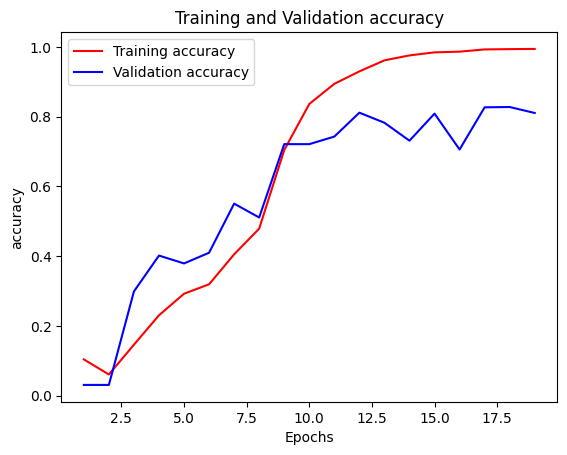

In [330]:
LC_plt(accuracy_train,accuracy_val,StartPoint=1,train_Label='Training accuracy',
           val_Label='Validation accuracy',title='Training and Validation accuracy',ylabel='accuracy')

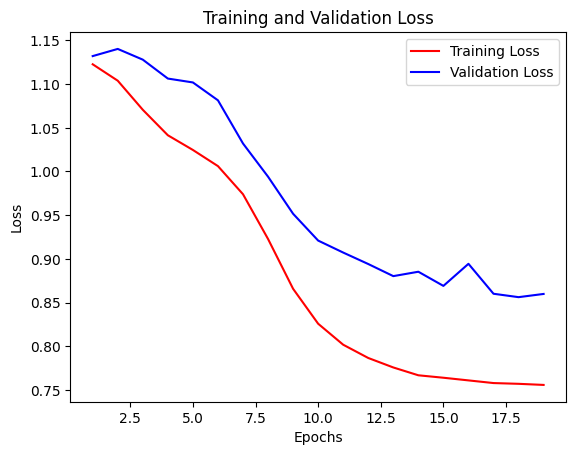

In [331]:
LC_plt(losses_outlabel_train,losses_outlabel_val,StartPoint=1)

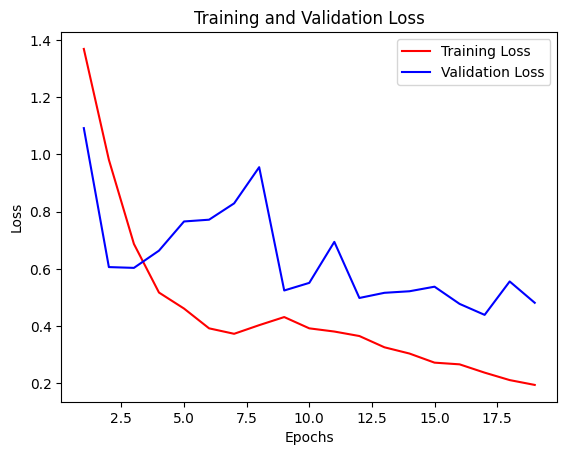

In [332]:
LC_plt(losses_outsev_train,losses_outsev_val,StartPoint=1)

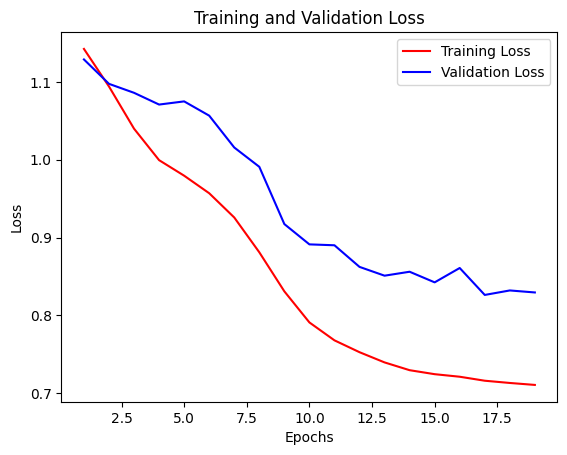

In [333]:
LC_plt(losses__train,losses_val,StartPoint=1)